# SDSSRM-XCS gas fraction: Evolution with mass?

This section of the project uses the properties measured in the first paper of this series [(Turner et al. 2024)](https://ui.adsabs.harvard.edu/abs/2025MNRAS.tmp...10T/abstract), specifically total/hydrostatic mass ($M_{\rm{tot}}$, or $M^{\rm{tot}}_{\Delta}$ within an overdensity radius $R_{\Delta}$), and hot gas mass of galaxy clusters and groups ($M_{\rm{gas}}$, or $M^{\rm{gas}}_{\Delta}$), to measure the gas fraction ($f_{\rm{gas}}$). This is ratio of mass contained in the hot ICM, to the overall halo mass, and in a perfect Universe would be 'set' just by the Universe's overall baryon fraction.

That is a simplification however, and in reality a whole host of factors contribute to shifting cluster $f_{\rm{gas}}$ from the cosmic value, not least of which is the fact that in **this measurement** we are not taking into account all the baryons in a cluster (some are locked in galaxies/stars, some are in cooler phases of the ICM). Other factors include feedback processes, which can have outsized effects on lower-mass clusters and groups, causing their hot ICM to 'puff up' and be pushed to the very outskirts of the halo. Previous work has identified an evolution of the baryon fraction with halo mass.

As the first paper of this series produced a dataset with measures of the total and hot-gas masses, and we have already measured $M_{\rm{tot}}$-$M_{\rm{gas}}$ scaling relations, we take this opportunity to make a new measure of the gas fraction in clusters

Scaling relation fits were performed using the XGA interface to the R scaling-relation fitting package LIRA, see the paper for full details.

## Main takeaways

In summary:

* We calculate $f_{\rm{gas}}$ distributions within $R_{2500}$ and $R_{500}$, using hydrostatic and gas masses from the first paper in this series. The $R_{2500}$ and $R_{500}$ distributions contains **91** and **104** clusters respectively.
* 

## Import Statements

In [31]:
from astropy.units import Quantity
from astropy.cosmology import Planck18
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import xcs_cosmo

## Loading data files and relations

We load the new SDSSRM-XCS scaling relations between total mass and gas mass, as they contain all the information required to calculate the gas fractions for the SDSSRM-XCS galaxy clusters. The relation data points will be used to create an $f_{\rm{gas}}$ distribution, and the relation fit models will constrain any mass evolution.

The 'base' SDSSRM-XCS sample file is also loaded, so that output gas fraction measurement files can have an entry for every cluster in the SDSSRM-XCS sample, even if we couldn't calculate an $f_{\rm{gas}}$ value because of a lack of cluster mass measurement.

### SDSSRM-XCS base sample

In [32]:
sdssxcs_base = pd.read_csv("../../sample_files/SDSSRM-XCS_base_sample.csv")
sdssxcs_base.head(6)

,name,MEM_MATCH_ID,xapa_ra,xapa_dec,rm_ra,rm_dec,z,r500,r500-,r500+,richness,richness_err,XCS_NAME,R_LAMBDA,xmm_targeted,xmm_serendipitous
0,SDSSXCS-124,124,0.80058,-6.09182,0.798261,-6.091694,0.2475,1181.028,21.202,23.203,109.550,4.490,XMMXCS J000312.1-060530.5,1.018410,Y,NaN
1,SDSSXCS-2789,2789,0.95554,2.06802,0.956981,2.066469,0.1053,1007.861,17.194,17.202,38.904,2.830,XMMXCS J000349.3+020404.8,0.827942,Y,NaN
2,SDSSXCS-290,290,2.72264,29.16102,2.714137,29.161154,0.3485,913.052,30.879,31.210,105.096,5.994,XMMXCS J001053.4+290939.6,1.009990,Y,NaN
3,SDSSXCS-1018,1018,4.40633,-0.87619,4.406711,-0.878340,0.2144,902.259,22.445,23.366,56.997,3.219,XMMXCS J001737.5-005234.2,0.893655,NaN,Y
4,SDSSXCS-134,134,4.90839,3.60982,4.911069,3.599257,0.2773,1123.321,19.219,19.226,108.604,4.792,XMMXCS J001938.0+033635.3,1.016645,Y,NaN
5,SDSSXCS-119,119,8.46470,-7.86290,8.471426,-7.869543,0.3042,944.275,46.422,46.747,128.192,5.697,XMMXCS J003351.5-075146.4,1.050926,Y,NaN


### $M^{\rm{tot}}_{500}$-$M^{\rm{gas}}_{500}$

In [2]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mtot-mgas/turner2025_mtot500_mgas500.xgarel', 'rb') as scalo:
    mtot500_mgas500 = pickle.load(scalo)

### $M^{\rm{tot}}_{2500}$-$M^{\rm{gas}}_{2500}$

In [3]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mtot-mgas/turner2025_mtot2500_mgas2500.xgarel', 'rb') as scalo:
    mtot2500_mgas2500 = pickle.load(scalo)

## Calculating $f_{\rm{gas}}$ distributions

We measure the $f_{\rm{gas}}$ value for the galaxy clusters in the new SDSSRM-XCS $M_{\rm{tot}}$-$M_{\rm{gas}}$ scaling relations - this results in two distributions, one for $f_{\rm{gas}}$ within $R_{2500}$ and another for $f_{\rm{gas}}$ within $R_{500}$. We make no attempt to measure an evolution of $f_{\rm{gas}}$ with halo mass at this point.

In [ ]:
# Measuring gas fractions is a simple calculation thankfully
gfrac_2500 = mtot2500_mgas2500.x_data[:, 0]/mtot2500_mgas2500.y_data[:, 0]

# TODO PROPAGATE ERRORS

gfrac_500 = mtot500_mgas500.x_data[:, 0]/mtot500_mgas500.y_data[:, 0]

### Visualizing the distributions

In [4]:
# Set up the bins for the fgas histogram; 0-1 in 0.025 wide steps
frac_bins = np.linspace(0, 1, 41)

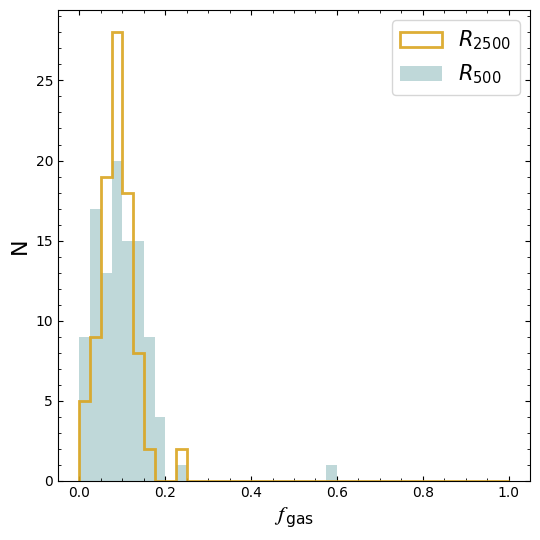

In [36]:
plt.figure(figsize=(5.5, 5.5))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

plt.hist(gfrac_2500, bins=frac_bins, color='goldenrod', alpha=0.9, histtype='step', label=r'$R_{2500}$', linewidth=2)
plt.hist(gfrac_500, bins=frac_bins, color='cadetblue', alpha=0.4, histtype='stepfilled', label=r'$R_{500}$')

plt.xlabel(r"$𝑓_{\rm{gas}}$", fontsize=16)
plt.ylabel(r"N", fontsize=16)

plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig("../../outputs/figures/gas_fraction/gas_frac_dist.pdf")
plt.show()

### Outputting gas $f_{\rm{gas}}$ values

We save the calculated $f_{\rm{gas}}$ values to a results file:

In [33]:
fgas_dat = []
fgas_col = []
fgas_df = pd.DataFrame(fgas_dat, columns=fgas_col)
# fgas_df.to_csv("../../outputs/result_files/gas_fractions.csv", index=False)